# Preview - AutoMPG

- Raw Link: https://docs.google.com/spreadsheets/d/e/2PACX-1vRHn-VvsM6-rRjBdkV-AhjPmVai2CrlCxpEYe8Mmtk1wsS5sGEft-5nJTk0V99Tw-hDLLgARISU5-d_/pub?output=csv

- Goal of this notebook is to paste a template version of the workflow from the ADMIN_Comparing_Datasets notebook.
 
**The code will:**
- Create 4 preprocessing pipelines (one with scaling and one without)
    - `preprocessor`
        - Clone: `preprocessor_cln`
    - `preprocessor_scale`
        - Clone: `preprocessor_scale_cln`    
    
- Create 4 Versions of the X/y data.
    - **All Data/Rows:**
        - Starting Vars:
            - df,X,y, X_train, X_test,y_train,y_test
        - **Unscaled**
            - Without a  constant:
                - X_train_df, X_test_df, y_train,y_test
            - With a constant:
                - X_train_df_cnst, X_test_df_cnst, y_train (same), y_test (same)
        - **Scaled:**
            - Without a  constant:
                - X_train_df_scaled, X_test_df_scaled, y_train (same), y_test (same)
            - With a constant:
                - X_train_df_scaled_cnst, X_test_df_scaled_cnst, y_train (same), y_test (same)

    - **Cleaned/Outliers Removed**
        - Starting Vars:
            - df_clean,X_cln,y_cln, X_train_cln, X_test_cln,y_train_cln,y_test_cln
        - **Unscaled**
            - Without a  constant:
                - X_train_df_cln, X_test_df_cln, y_train,y_test
            - With a constant:
                - X_train_df_cln_cnst, X_test_df_cln_cnst, y_train_cln (same), y_test_cln (same)
        - **Scaled:**
            - Without a  constant:
                - X_train_df_cln_scaled, X_test_df_cln_scaled, y_train_cln (same), y_test_cln (same)
            - With a constant:
                - X_train_df_scaled_cln_cnst, X_test_df_cln_scaled_cnst, y_train_cln (same), y_test_cln (same)

# Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.base import clone

## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm
from scipy import stats

## Customized Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
# plt.style.use('seaborn-talk')

In [2]:
## Adding folder above to path
import os, sys
sys.path.append(os.path.abspath('../'))

## Load stack_functions with autoreload turned on
%load_ext autoreload
%autoreload 2
from CODE import stack_functions as sf

def show_code(function):
    import inspect 
    from IPython.display import display,Markdown, display_markdown
    code = inspect.getsource(function)
    md_txt = f"```python\n{code}\n```"
    return display(Markdown(md_txt))
    

## Preliminary Checks and Dtype Conversion

- Change:
    - `FILE`: url or filepath to load
    - `DROP_COLS`: list of columns to drop from df
    - `CONVERT_TO_STR_COLS`: numeric cols to convert to str
    - `CONVERT_TO_NUM_COLS`: str cols to convert to numeric (uses pd.to_numeric)

In [3]:
## Load in data
FILE = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRHn-VvsM6-rRjBdkV-AhjPmVai2CrlCxpEYe8Mmtk1wsS5sGEft-5nJTk0V99Tw-hDLLgARISU5-d_/pub?output=csv"


df = pd.read_csv(FILE)

In [4]:
from pandas_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 27.7+ KB


mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0         130    3504          12.0   
1  15.0          8         350.0         165    3693          11.5   
2  18.0          8         318.0         150    3436          11.0   
3  16.0          8         304.0         150    3433          12.0   
4  17.0          8         302.0         140    3449          10.5   

   model year  origin                   car name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino

In [6]:
## Drop unwanted columns
DROP_COLS = ['car name']#'id','date']
df = df.drop(columns=DROP_COLS)

In [7]:
## Convert all categories to strings
CONVERT_TO_STR_COLS = ['origin']
df[CONVERT_TO_STR_COLS] = df[CONVERT_TO_STR_COLS].astype(str)

CONVERT_TO_NUM_COLS = []
for col in CONVERT_TO_NUM_COLS:
    df[col] = pd.to_numeric(df[col])

In [8]:
## final info before X/y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    object 
dtypes: float64(3), int64(4), object(1)
memory usage: 24.6+ KB


## Full Dataset Preprocessing

In [9]:
## Make x and y variables
target = 'mpg'#'price'
drop_cols_model = []

y = df[target].copy()
X = df.drop(columns=[target,*drop_cols_model]).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train.head()

cylinders  displacement  horsepower  weight  acceleration  model year  \
295          5         183.0          77    3530          20.1          79   
214          4          98.0          68    2045          18.5          77   
48           4         122.0          86    2220          14.0          71   
302          4          91.0          69    2130          14.7          79   
160          6         258.0         110    3730          19.0          75   

    origin  
295      2  
214      3  
48       1  
302      2  
160      1

### Unscaled

In [10]:
## cat selector
cat_sel = make_column_selector(dtype_include='object')
cat_cols = cat_sel(X)

# num selectorr
num_sel = make_column_selector(dtype_include='number')
num_cols = num_sel(X)

## make pipelines & column transformer - raw numeric
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_pipe_raw = make_pipeline(SimpleImputer(strategy='mean'))
preprocessor = make_column_transformer((num_pipe_raw, num_sel),
                                       (cat_pipe,cat_sel), verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x294912be0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x294912340>)],
                  verbose_feature_names_out=False)

In [11]:
### PREP ALL X VARS
## Prepare X_train_df
X_train_df = pd.DataFrame( preprocessor.fit_transform(X_train), 
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)

## Prepare X_test_df
X_test_df = pd.DataFrame( preprocessor.transform(X_test),
                         columns=preprocessor.get_feature_names_out(), 
                         index=X_test.index)


## Prepare X vars with constant
X_train_df_cnst = sm.add_constant(X_train_df, prepend=False, has_constant='add')
X_test_df_cnst = sm.add_constant(X_test_df, prepend=False, has_constant='add')

In [12]:
X_train_df.describe()

cylinders  displacement  horsepower       weight  acceleration  \
count  294.000000    294.000000  294.000000   294.000000    294.000000   
mean     5.551020    197.096939  104.482993  2994.146259     15.595238   
std      1.731789    104.855166   38.106704   859.871442      2.803991   
min      3.000000     68.000000   46.000000  1613.000000      8.000000   
25%      4.000000     98.000000   75.000000  2220.750000     13.625000   
50%      5.000000    151.000000   94.500000  2880.000000     15.500000   
75%      8.000000    302.000000  130.000000  3641.750000     17.275000   
max      8.000000    455.000000  225.000000  5140.000000     24.800000   

       model year    origin_1    origin_2    origin_3  
count  294.000000  294.000000  294.000000  294.000000  
mean    75.993197    0.646259    0.156463    0.197279  
std      3.691142    0.478945    0.363913    0.398623  
min     70.000000    0.000000    0.000000    0.000000  
25%     73.000000    0.000000    0.000000    0.000000  
50%     76.000000    1.000000    0.000000    0.000000  
75%     79.000000    1.000000    0.000000    0.000000  
max     82.000000    1.000000    1.000000    1.000000

> The cell below should be updated for each dataset- only separating high cardinality OHE features (e.g. zipcode)

In [13]:
## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df.drop(columns=[*ohe_cols]).columns.tolist()

### Scaled

In [14]:
## make pipelines & column transformer - scaled
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe_scale = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
preprocessor_scale = make_column_transformer((num_pipe_scale, num_sel),
                                       (cat_pipe,cat_sel), verbose_feature_names_out=False)
preprocessor_scale

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x294912be0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x294912340>)],
                  verbose_feature_names_out=False)

In [15]:
# ### PREP ALL SCALED X VARS


# Prepare X_train_scaled_df & X_test_scaled_df
X_train_scaled_df = pd.DataFrame( preprocessor_scale.fit_transform(X_train), 
                          columns=preprocessor_scale.get_feature_names_out(),
                         index=X_train.index)


X_test_scaled_df = pd.DataFrame( preprocessor_scale.transform(X_test),
                         columns=preprocessor_scale.get_feature_names_out(), 
                         index=X_test.index)


## Save vers with constant
X_train_scaled_df_cnst = sm.add_constant(X_train_scaled_df, prepend=False, has_constant='add')
X_test_scaled_df_cnst = sm.add_constant(X_test_scaled_df, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df.drop(columns=[*ohe_cols]).columns.tolist()


X_test_scaled_df.head()

cylinders  displacement  horsepower    weight  acceleration  model year  \
58   -0.897144     -0.956249   -1.327039 -0.862231      2.823918   -1.083677   
234  -0.897144     -0.545460   -0.406999 -0.278593      0.073150    0.273227   
300  -0.897144     -0.879823   -0.906449 -0.983386     -0.248369    0.815989   
278   0.259700      0.323884    0.276459  0.292231     -0.069747    0.815989   
321  -0.897144     -0.392608    0.013590 -0.226170     -0.426990    1.087369   

     origin_1  origin_2  origin_3  
58        0.0       1.0       0.0  
234       1.0       0.0       0.0  
300       1.0       0.0       0.0  
278       1.0       0.0       0.0  
321       1.0       0.0       0.0

In [16]:
X_train_scaled_df.describe()

cylinders  displacement    horsepower        weight  acceleration  \
count  2.940000e+02  2.940000e+02  2.940000e+02  2.940000e+02  2.940000e+02   
mean   1.208406e-17 -6.042030e-17 -1.087565e-16 -8.458842e-17  1.042250e-16   
std    1.001705e+00  1.001705e+00  1.001705e+00  1.001705e+00  1.001705e+00   
min   -1.475566e+00 -1.233292e+00 -1.537333e+00 -1.608963e+00 -2.713342e+00   
25%   -8.971443e-01 -9.466954e-01 -7.750149e-01 -9.009660e-01 -7.038529e-01   
50%   -3.187223e-01 -4.403744e-01 -2.624214e-01 -1.329744e-01 -3.402310e-02   
75%    1.416544e+00  1.002163e+00  6.707616e-01  7.544243e-01  6.000825e-01   
max    1.416544e+00  2.463806e+00  3.168012e+00  2.499807e+00  3.288333e+00   

         model year    origin_1    origin_2    origin_3  
count  2.940000e+02  294.000000  294.000000  294.000000  
mean  -4.229421e-16    0.646259    0.156463    0.197279  
std    1.001705e+00    0.478945    0.363913    0.398623  
min   -1.626439e+00    0.000000    0.000000    0.000000  
25%   -8.122963e-01    0.000000    0.000000    0.000000  
50%    1.846128e-03    1.000000    0.000000    0.000000  
75%    8.159886e-01    1.000000    0.000000    0.000000  
max    1.630131e+00    1.000000    1.000000    1.000000

## Cleaned Dataset Preprocessing

### Remove Outliers

In [17]:
show_code(sf.remove_outliers)

```python
def remove_outliers(df_,method='iqr', subset=None, verbose=2):
    """Returns a copy of the input df with outleirs removed from all
    columns using the selected method (either 'iqr' or 'z'/'zscore')
    
    Arguments:
        df_ (Frame): Dataframe to copy and remove outleirs from
        method (str): Method of outlier removal. Options are 'iqr' or 'z' (default is 'iqr')
        subset (list or None): List of column names to remove outliers from. If None, uses all numeric columns.
        verbose (bool, int): If verbose==1, print only overall summary. If verbose==2, print detailed summary"""
    import pandas as pd
    ## Make a cope of input dataframe  
    df = df_.copy()
    
    ## Set verbose_func for calls to outleir funcs
    if verbose==2:
        verbose_func = True
    else:
        verbose_func=False
        
    ## Set outlier removal function and name
    if method.lower()=='iqr':
        find_outlier_func = find_outliers_IQR
        method_name = "IQR rule"
    elif 'z' in method.lower():
        find_outlier_func = find_outliers_Z
        method_name = 'Z_score rule'
    else:
        raise Exception('[!] Method must be either "iqr" or "z".')
        
    ## Set list of cols to remove outliers from
    if subset is None:
        col_list = df.select_dtypes('number').columns
    elif isinstance(subset,str):
        col_list = [subset]
    elif isinstance(susbet, list):
        col_list = subset
    else:
        raise Exception("[!] subset must be None, a single string, or a list of strings.")

    

    
    ## Empty dict for both types of outliers
    outliers = {}

    ## Use both functions to see the comparison for # of outliers
    for col in col_list:
        idx_outliers = find_outlier_func(df[col],verbose=verbose_func)
        outliers[col] = idx_outliers

    
    ## Getting final df of all outliers to get 1 final T/F index
    outliers_combined = pd.DataFrame(outliers).any(axis=1)
    
    if verbose:
        n = len(outliers_combined)
        print(f"\n[i] Overall, {outliers_combined.sum():,} rows out of {n:,}({outliers_combined.sum()/n*100:.2f}%) were removed as outliers using {method_name}.")
    
    
    # remove_outliers 
    df_clean = df[~outliers_combined].copy()
    return df_clean

```

In [18]:
df_clean_iqr = sf.remove_outliers(df,verbose=2)
df_clean_iqr

- 0 outliers found in mpg out of 392 rows (0.00%) using IQR.
- 0 outliers found in cylinders out of 392 rows (0.00%) using IQR.
- 0 outliers found in displacement out of 392 rows (0.00%) using IQR.
- 10 outliers found in horsepower out of 392 rows (2.55%) using IQR.
- 0 outliers found in weight out of 392 rows (0.00%) using IQR.
- 11 outliers found in acceleration out of 392 rows (2.81%) using IQR.
- 0 outliers found in model year out of 392 rows (0.00%) using IQR.

[i] Overall, 20 rows out of 392(5.10%) were removed as outliers using IQR rule.


mpg  cylinders  displacement  horsepower  weight  acceleration  \
0    18.0          8         307.0         130    3504          12.0   
1    15.0          8         350.0         165    3693          11.5   
2    18.0          8         318.0         150    3436          11.0   
3    16.0          8         304.0         150    3433          12.0   
4    17.0          8         302.0         140    3449          10.5   
..    ...        ...           ...         ...     ...           ...   
386  27.0          4         151.0          90    2950          17.3   
387  27.0          4         140.0          86    2790          15.6   
389  32.0          4         135.0          84    2295          11.6   
390  28.0          4         120.0          79    2625          18.6   
391  31.0          4         119.0          82    2720          19.4   

     model year origin  
0            70      1  
1            70      1  
2            70      1  
3            70      1  
4            70      1  
..          ...    ...  
386          82      1  
387          82      1  
389          82      1  
390          82      1  
391          82      1  

[372 rows x 8 columns]

In [19]:
df_clean_z = sf.remove_outliers(df,method='z')
df_clean_z

- 0 outliers found in mpg out of 392 rows (0.00%) using Z-scores.
- 0 outliers found in cylinders out of 392 rows (0.00%) using Z-scores.
- 0 outliers found in displacement out of 392 rows (0.00%) using Z-scores.
- 5 outliers found in horsepower out of 392 rows (1.28%) using Z-scores.
- 0 outliers found in weight out of 392 rows (0.00%) using Z-scores.
- 2 outliers found in acceleration out of 392 rows (0.51%) using Z-scores.
- 0 outliers found in model year out of 392 rows (0.00%) using Z-scores.

[i] Overall, 7 rows out of 392(1.79%) were removed as outliers using Z_score rule.


mpg  cylinders  displacement  horsepower  weight  acceleration  \
0    18.0          8         307.0         130    3504          12.0   
1    15.0          8         350.0         165    3693          11.5   
2    18.0          8         318.0         150    3436          11.0   
3    16.0          8         304.0         150    3433          12.0   
4    17.0          8         302.0         140    3449          10.5   
..    ...        ...           ...         ...     ...           ...   
386  27.0          4         151.0          90    2950          17.3   
387  27.0          4         140.0          86    2790          15.6   
389  32.0          4         135.0          84    2295          11.6   
390  28.0          4         120.0          79    2625          18.6   
391  31.0          4         119.0          82    2720          19.4   

     model year origin  
0            70      1  
1            70      1  
2            70      1  
3            70      1  
4            70      1  
..          ...    ...  
386          82      1  
387          82      1  
389          82      1  
390          82      1  
391          82      1  

[385 rows x 8 columns]

In [20]:
## Make x and y variables
# target = 'price'
# drop_cols_model = []

y_cln = df_clean_z[target].copy()
X_cln = df_clean_z.drop(columns=[target,*drop_cols_model]).copy()

X_train_cln, X_test_cln, y_train_cln, y_test_cln = train_test_split(X_cln,y_cln, random_state=321)
X_train_cln.head()

cylinders  displacement  horsepower  weight  acceleration  model year  \
283          8         305.0         130    3840          15.4          79   
51           4          88.0          76    2065          14.5          71   
235          4          98.0          63    2051          17.0          77   
387          4         140.0          86    2790          15.6          82   
63           8         318.0         150    4135          13.5          72   

    origin  
283      1  
51       2  
235      1  
387      1  
63       1

### Unscaled

In [21]:
## Cloning the Previous 2 Preprocessors
preprocessor_cln = clone(preprocessor)
preprocessor_cln_scale = clone(preprocessor_scale)

In [22]:
### PREP ALL X VARS
## Prepare X_train_df
X_train_df_cln = pd.DataFrame( preprocessor_cln.fit_transform(X_train_cln), 
                          columns=preprocessor_cln.get_feature_names_out(),
                         index=X_train_cln.index)

## Prepare X_test_df
X_test_df_cln = pd.DataFrame( preprocessor_cln.transform(X_test_cln),
                         columns=preprocessor_cln.get_feature_names_out(), 
                         index=X_test_cln.index)


## Prepare X vars with constant
X_train_df_cln_cnst = sm.add_constant(X_train_df_cln, prepend=False, has_constant='add')
X_test_df_cln_cnst = sm.add_constant(X_test_df_cln, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df_cln.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df_cln.drop(columns=[*ohe_cols]).columns.tolist()

X_test_df.head()

cylinders  displacement  horsepower  weight  acceleration  model year  \
58         4.0          97.0        54.0  2254.0          23.5        72.0   
234        4.0         140.0        89.0  2755.0          15.8        77.0   
300        4.0         105.0        70.0  2150.0          14.9        79.0   
278        6.0         231.0       115.0  3245.0          15.4        79.0   
321        4.0         156.0       105.0  2800.0          14.4        80.0   

     origin_1  origin_2  origin_3  
58        0.0       1.0       0.0  
234       1.0       0.0       0.0  
300       1.0       0.0       0.0  
278       1.0       0.0       0.0  
321       1.0       0.0       0.0

In [23]:
X_train_df_cln.describe()

cylinders  displacement  horsepower       weight  acceleration  \
count  288.000000    288.000000  288.000000   288.000000    288.000000   
mean     5.413194    190.470486  101.958333  2954.739583     15.686806   
std      1.694251    100.564755   35.882964   841.010843      2.622610   
min      3.000000     68.000000   46.000000  1649.000000      8.000000   
25%      4.000000    104.750000   75.000000  2213.750000     14.000000   
50%      4.000000    140.500000   90.000000  2747.500000     15.500000   
75%      8.000000    260.500000  120.000000  3571.000000     17.200000   
max      8.000000    429.000000  215.000000  5140.000000     23.700000   

       model year    origin_1    origin_2    origin_3  
count  288.000000  288.000000  288.000000  288.000000  
mean    76.027778    0.652778    0.184028    0.163194  
std      3.687146    0.476916    0.388181    0.370186  
min     70.000000    0.000000    0.000000    0.000000  
25%     73.000000    0.000000    0.000000    0.000000  
50%     76.000000    1.000000    0.000000    0.000000  
75%     79.000000    1.000000    0.000000    0.000000  
max     82.000000    1.000000    1.000000    1.000000

### Scaled

In [24]:
# ### PREP ALL SCALED X VARS


# Prepare X_train_scaled_df & X_test_scaled_df
X_train_scaled_df_cln = pd.DataFrame( preprocessor_cln_scale.fit_transform(X_train_cln), 
                          columns=preprocessor_cln_scale.get_feature_names_out(),
                         index=X_train_cln.index)


X_test_scaled_df_cln = pd.DataFrame( preprocessor_cln_scale.transform(X_test_cln),
                         columns=preprocessor_cln_scale.get_feature_names_out(), 
                         index=X_test_cln.index)


## Save vers with constant
X_train_scaled_df_cln_cnst = sm.add_constant(X_train_scaled_df_cln, prepend=False, has_constant='add')
X_test_scaled_df_cln_cnst = sm.add_constant(X_test_scaled_df_cln, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_scaled_df_cln.columns if c.startswith('zipcode')]
nonohe_cols = X_train_scaled_df_cln.drop(columns=[*ohe_cols]).columns.tolist()


X_train_scaled_df_cln.head()

cylinders  displacement  horsepower    weight  acceleration  model year  \
283   1.529471      1.140846    0.782836  1.054447     -0.109549    0.807507   
51   -0.835563     -1.020724   -0.724676 -1.059782     -0.453316   -1.365970   
235  -0.835563     -0.921112   -1.087595 -1.076458      0.501592    0.264138   
387  -0.835563     -0.502744   -0.445507 -0.196224     -0.033157    1.622561   
63    1.529471      1.270341    1.341174  1.405826     -0.835279   -1.094285   

     origin_1  origin_2  origin_3  
283       1.0       0.0       0.0  
51        0.0       1.0       0.0  
235       1.0       0.0       0.0  
387       1.0       0.0       0.0  
63        1.0       0.0       0.0

In [25]:
X_train_scaled_df_cln.describe()

cylinders  displacement    horsepower        weight  acceleration  \
count  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02   
mean  -1.171902e-16 -3.392348e-17  1.449458e-16 -1.819532e-16 -4.934325e-16   
std    1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00   
min   -1.426822e+00 -1.219947e+00 -1.562182e+00 -1.555286e+00 -2.936077e+00   
25%   -8.355634e-01 -8.538746e-01 -7.525927e-01 -8.826038e-01 -6.442977e-01   
50%   -8.355634e-01 -4.977635e-01 -3.338394e-01 -2.468462e-01 -7.135286e-02   
75%    1.529471e+00  6.975745e-01  5.036672e-01  7.340370e-01  5.779847e-01   
max    1.529471e+00  2.376028e+00  3.155771e+00  2.602896e+00  3.060746e+00   

         model year    origin_1    origin_2    origin_3  
count  2.880000e+02  288.000000  288.000000  288.000000  
mean   1.739349e-15    0.652778    0.184028    0.163194  
std    1.001741e+00    0.476916    0.388181    0.370186  
min   -1.637654e+00    0.000000    0.000000    0.000000  
25%   -8.226005e-01    0.000000    0.000000    0.000000  
50%   -7.546794e-03    1.000000    0.000000    0.000000  
75%    8.075069e-01    1.000000    0.000000    0.000000  
max    1.622561e+00    1.000000    1.000000    1.000000

## Modeling - Full Dataset

### Raw Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     172.3
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          1.89e-104
Time:                        14:51:39   Log-Likelihood:                -766.33
No. Observations:                 294   AIC:                             1551.
Df Residuals:                     285   BIC:                             1584.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.4756      0.374     -1.273      0.204      -1.211       0.260
displacement     0.0260      0.009      2.931      0.004       0.009       0.044
horsepower      -0.0291      0.017     -1.760      0.080      -0.062       0.003
weight          -0.0064      0.001     -8.657      0.000      -0.008      -0.005
acceleration     0.0898      0.113      0.793      0.428      -0.133       0.313
model year       0.7814      0.060     13.085      0.000       0.664       0.899
origin_1       -18.9226      5.341     -3.543      0.000     -29.436      -8.409
origin_2       -15.4499      5.298     -2.916      0.004     -25.879      -5.021
origin_3       -15.6273      5.346     -2.923      0.004     -26.150      -5.105
==============================================================================
Omnibus:                       16.586   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.615
Skew:                           0.409   Prob(JB):                     7.45e-06
Kurtosis:                       4.121   Cond. No.                     1.48e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

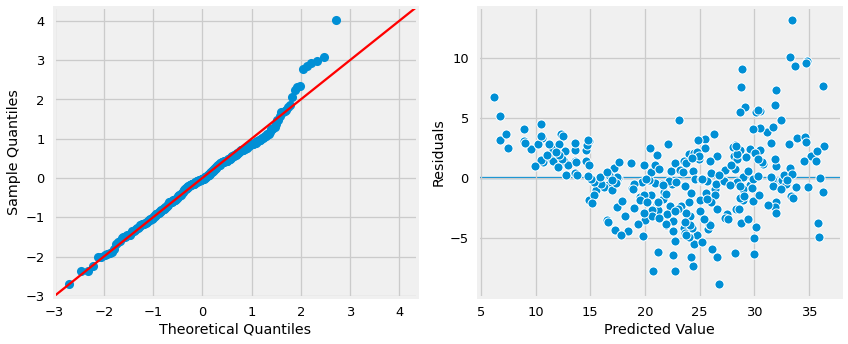

In [26]:
## instantiate an OLS model WITH the training data.
model_raw = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result_raw = model_raw.fit()
sf.evaluate_ols(result_raw,X_train_df, y_train)

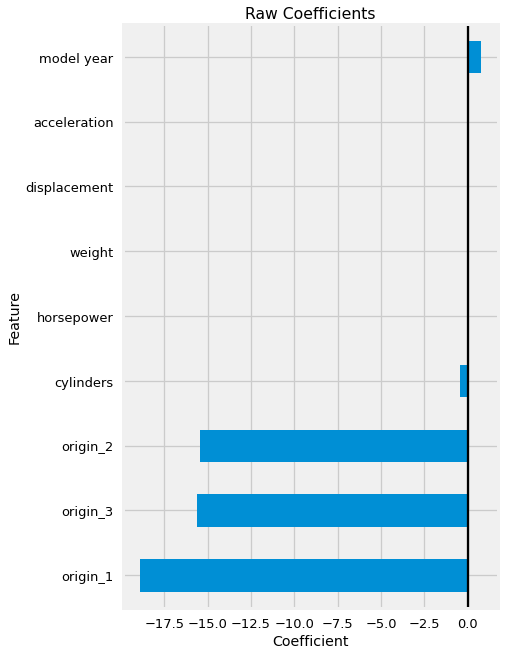

In [27]:
fig_raw = sf.plot_coeffs(result_raw, ohe_cols, include_const=True,title="Raw Coefficients")

In [28]:
fig_raw_zips =sf.plot_coeffs(result_raw, nonohe_cols, figsize=(6,12),
                           include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Raw Numeric - with Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     172.3
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          1.89e-104
Time:                        14:51:39   Log-Likelihood:                -766.33
No. Observations:                 294   AIC:                             1551.
Df Residuals:                     285   BIC:                             1584.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.4756      0.374     -1.273      0.204      -1.211       0.260
displacement     0.0260      0.009      2.931      0.004       0.009       0.044
horsepower      -0.0291      0.017     -1.760      0.080      -0.062       0.003
weight          -0.0064      0.001     -8.657      0.000      -0.008      -0.005
acceleration     0.0898      0.113      0.793      0.428      -0.133       0.313
model year       0.7814      0.060     13.085      0.000       0.664       0.899
origin_1        -6.4226      1.395     -4.606      0.000      -9.168      -3.678
origin_2        -2.9499      1.355     -2.176      0.030      -5.618      -0.282
origin_3        -3.1274      1.400     -2.234      0.026      -5.882      -0.372
const          -12.4999      3.986     -3.136      0.002     -20.346      -4.654
==============================================================================
Omnibus:                       16.586   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.615
Skew:                           0.409   Prob(JB):                     7.45e-06
Kurtosis:                       4.121   Cond. No.                     2.19e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.01e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

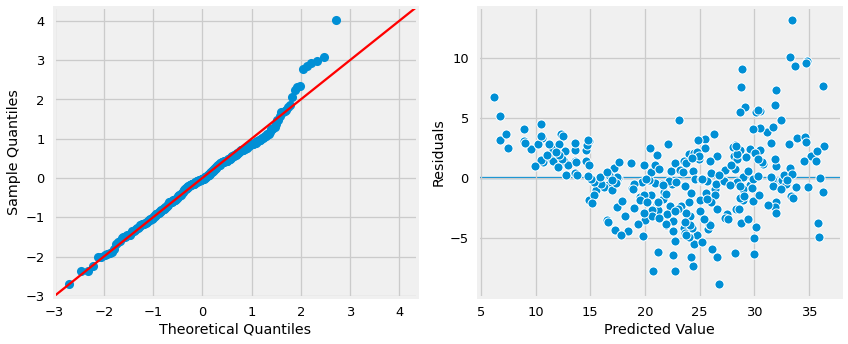

In [29]:
## instantiate an OLS model WITH the training data.
model_raw_cnst = sm.OLS(y_train, X_train_df_cnst)

## Fit the model and view the summary
result_raw_cnst = model_raw_cnst.fit()
sf.evaluate_ols(result_raw_cnst,X_train_df_cnst, y_train)

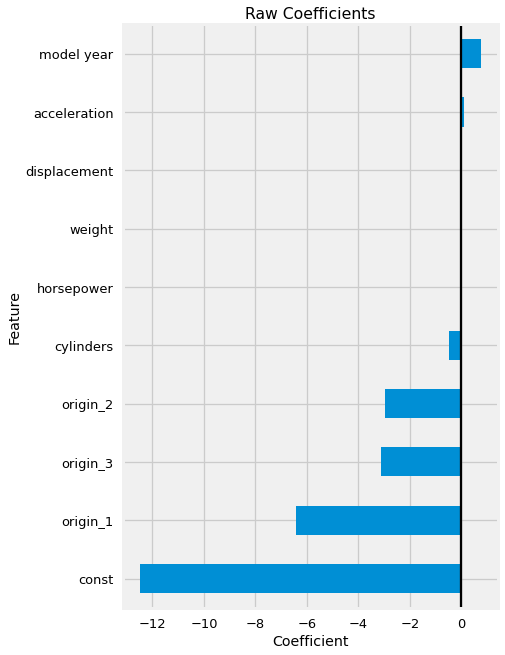

In [30]:
fig_raw =sf.plot_coeffs(result_raw_cnst, ohe_cols, include_const=True,title="Raw Coefficients")

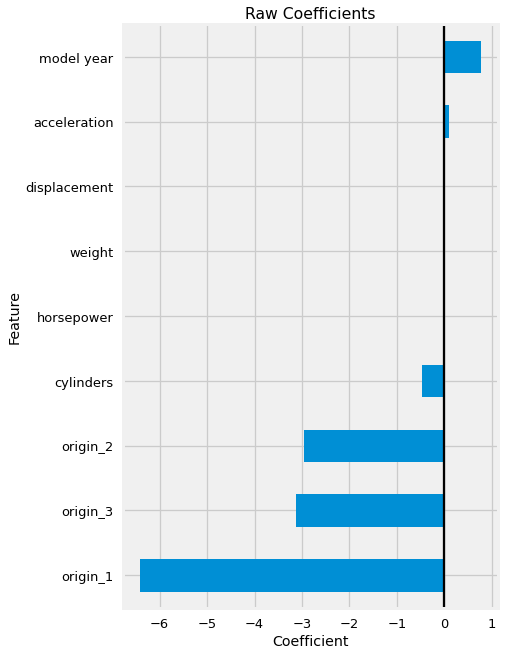

In [31]:
fig_raw =sf.plot_coeffs(result_raw_cnst, ohe_cols, include_const=False,title="Raw Coefficients")

In [32]:
fig_raw_zips =sf.plot_coeffs(result_raw_cnst, nonohe_cols, figsize=(6,12),include_const=False,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     172.3
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          1.89e-104
Time:                        14:51:40   Log-Likelihood:                -766.33
No. Observations:                 294   AIC:                             1551.
Df Residuals:                     285   BIC:                             1584.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.8223      0.646     -1.273      0.204      -2.094       0.449
displacement     2.7266      0.930      2.931      0.004       0.895       4.558
horsepower      -1.1079      0.630     -1.760      0.080      -2.347       0.131
weight          -5.4966      0.635     -8.657      0.000      -6.746      -4.247
acceleration     0.2514      0.317      0.793      0.428      -0.373       0.875
model year       2.8795      0.220     13.085      0.000       2.446       3.313
origin_1        22.1403      0.280     79.117      0.000      21.589      22.691
origin_2        25.6129      0.551     46.470      0.000      24.528      26.698
origin_3        25.4355      0.522     48.763      0.000      24.409      26.462
==============================================================================
Omnibus:                       16.586   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.615
Skew:                           0.409   Prob(JB):                     7.45e-06
Kurtosis:                       4.121   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

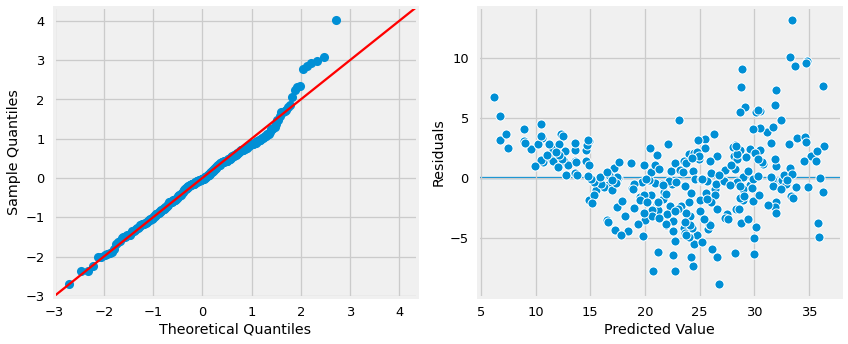

In [33]:
## instantiate an OLS model WITH the training data.
model_scaled = sm.OLS(y_train, X_train_scaled_df)

## Fit the model and view the summary
result_scaled = model_scaled.fit()
sf.evaluate_ols(result_scaled,X_train_scaled_df, y_train)

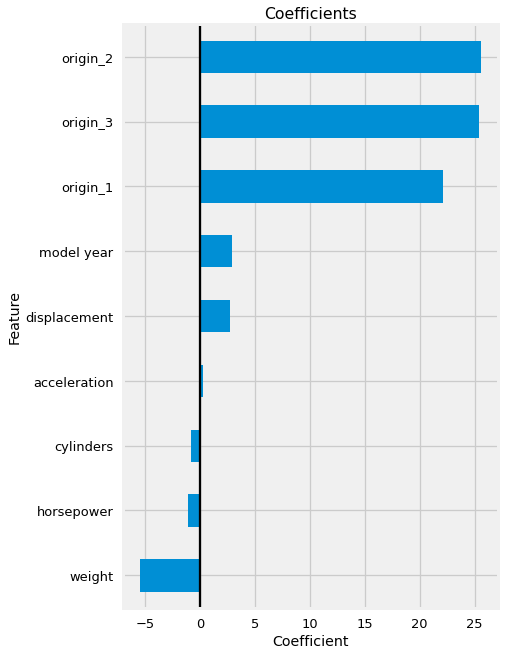

In [34]:
fig_scaled =sf.plot_coeffs(result_scaled,ohe_cols,include_const=True)

In [35]:
fig_scaled_zips =sf.plot_coeffs(result_scaled, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - with Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     172.3
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          1.89e-104
Time:                        14:51:40   Log-Likelihood:                -766.33
No. Observations:                 294   AIC:                             1551.
Df Residuals:                     285   BIC:                             1584.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.8223      0.646     -1.273      0.204      -2.094       0.449
displacement     2.7266      0.930      2.931      0.004       0.895       4.558
horsepower      -1.1079      0.630     -1.760      0.080      -2.347       0.131
weight          -5.4966      0.635     -8.657      0.000      -6.746      -4.247
acceleration     0.2514      0.317      0.793      0.428      -0.373       0.875
model year       2.8795      0.220     13.085      0.000       2.446       3.313
origin_1         3.8431      0.338     11.359      0.000       3.177       4.509
origin_2         7.3158      0.422     17.329      0.000       6.485       8.147
origin_3         7.1383      0.407     17.560      0.000       6.338       7.938
const           18.2972      0.198     92.360      0.000      17.907      18.687
==============================================================================
Omnibus:                       16.586   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.615
Skew:                           0.409   Prob(JB):                     7.45e-06
Kurtosis:                       4.121   Cond. No.                     1.39e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.73e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

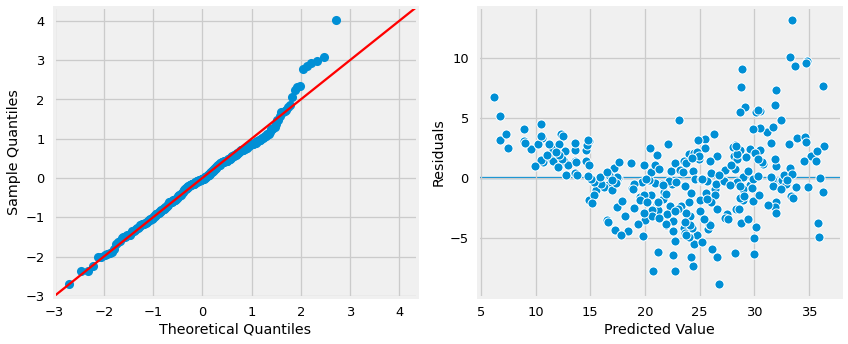

In [36]:
## instantiate an OLS model WITH the training data.
model_scaled_cnst = sm.OLS(y_train, X_train_scaled_df_cnst)

## Fit the model and view the summary
result_scaled_cnst = model_scaled_cnst.fit()
sf.evaluate_ols(result_scaled_cnst,X_train_scaled_df_cnst, y_train)

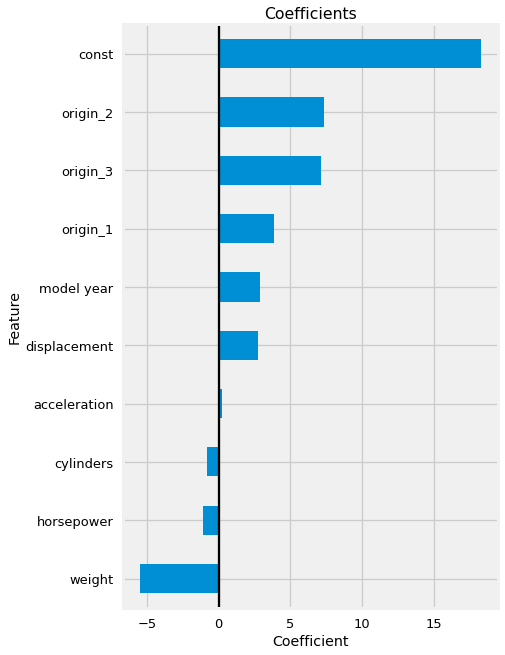

In [37]:
fig_scaled =sf.plot_coeffs(result_scaled_cnst,ohe_cols,include_const=True)

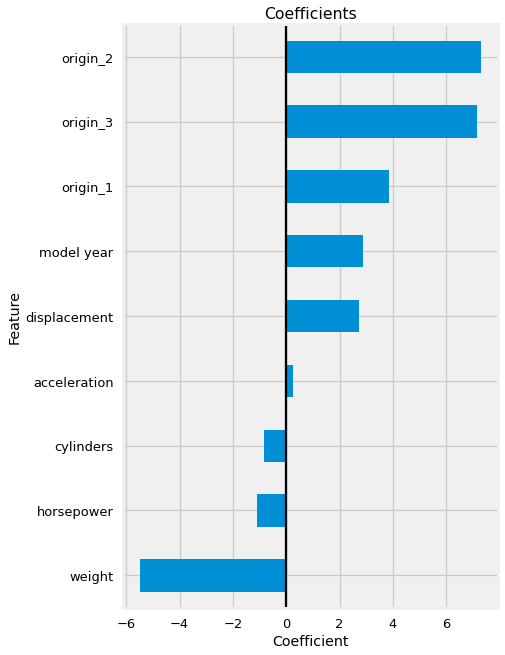

In [38]:
fig_scaled =sf.plot_coeffs(result_scaled_cnst,ohe_cols,include_const=False)

In [39]:
fig_scaled_zips =sf.plot_coeffs(result_scaled_cnst, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


## Modeling - No Outliers

### Raw Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     178.5
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          5.24e-105
Time:                        14:51:40   Log-Likelihood:                -727.36
No. Observations:                 288   AIC:                             1473.
Df Residuals:                     279   BIC:                             1506.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.1213      0.382     -0.318      0.751      -0.873       0.630
displacement     0.0108      0.010      1.124      0.262      -0.008       0.030
horsepower      -0.0202      0.016     -1.273      0.204      -0.051       0.011
weight          -0.0063      0.001     -7.445      0.000      -0.008      -0.005
acceleration    -0.0593      0.111     -0.533      0.595      -0.278       0.160
model year       0.7467      0.056     13.305      0.000       0.636       0.857
origin_1       -13.8020      5.186     -2.661      0.008     -24.011      -3.593
origin_2       -11.6805      5.069     -2.304      0.022     -21.659      -1.702
origin_3       -11.8137      5.187     -2.278      0.023     -22.024      -1.604
==============================================================================
Omnibus:                       16.085   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.422
Skew:                           0.350   Prob(JB):                     1.83e-06
Kurtosis:                       4.309   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

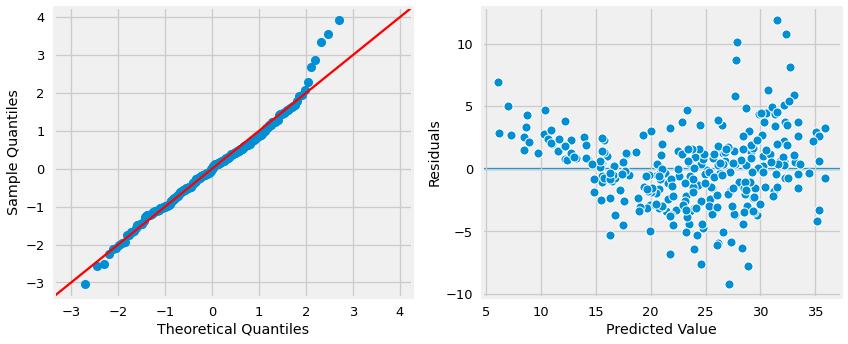

In [40]:
## instantiate an OLS model WITH the training data.
model_cln = sm.OLS(y_train_cln, X_train_df_cln)

## Fit the model and view the summary
result_cln = model_cln.fit()
sf.evaluate_ols(result_cln,X_train_df_cln, y_train_cln)

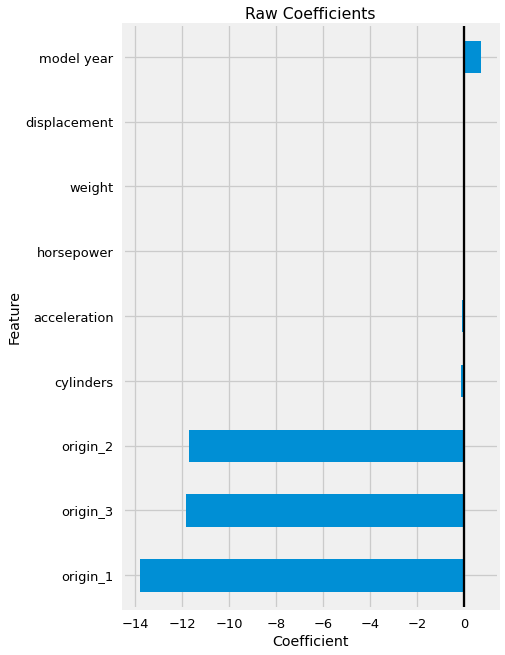

In [41]:
fig_raw =sf.plot_coeffs(result_cln, ohe_cols, include_const=True,title="Raw Coefficients")

In [42]:
fig_raw_zips =sf.plot_coeffs(result_cln, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Raw Numeric - with Constant

In [43]:
X_train_df_cln_cnst.describe()

cylinders  displacement  horsepower       weight  acceleration  \
count  288.000000    288.000000  288.000000   288.000000    288.000000   
mean     5.413194    190.470486  101.958333  2954.739583     15.686806   
std      1.694251    100.564755   35.882964   841.010843      2.622610   
min      3.000000     68.000000   46.000000  1649.000000      8.000000   
25%      4.000000    104.750000   75.000000  2213.750000     14.000000   
50%      4.000000    140.500000   90.000000  2747.500000     15.500000   
75%      8.000000    260.500000  120.000000  3571.000000     17.200000   
max      8.000000    429.000000  215.000000  5140.000000     23.700000   

       model year    origin_1    origin_2    origin_3  const  
count  288.000000  288.000000  288.000000  288.000000  288.0  
mean    76.027778    0.652778    0.184028    0.163194    1.0  
std      3.687146    0.476916    0.388181    0.370186    0.0  
min     70.000000    0.000000    0.000000    0.000000    1.0  
25%     73.000000    0.000000    0.000000    0.000000    1.0  
50%     76.000000    1.000000    0.000000    0.000000    1.0  
75%     79.000000    1.000000    0.000000    0.000000    1.0  
max     82.000000    1.000000    1.000000    1.000000    1.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     178.5
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          5.24e-105
Time:                        14:51:41   Log-Likelihood:                -727.36
No. Observations:                 288   AIC:                             1473.
Df Residuals:                     279   BIC:                             1506.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.1213      0.382     -0.318      0.751      -0.873       0.630
displacement     0.0108      0.010      1.124      0.262      -0.008       0.030
horsepower      -0.0202      0.016     -1.273      0.204      -0.051       0.011
weight          -0.0063      0.001     -7.445      0.000      -0.008      -0.005
acceleration    -0.0593      0.111     -0.533      0.595      -0.278       0.160
model year       0.7467      0.056     13.305      0.000       0.636       0.857
origin_1        -4.4779      1.367     -3.277      0.001      -7.168      -1.788
origin_2        -2.3564      1.257     -1.875      0.062      -4.830       0.118
origin_3        -2.4897      1.372     -1.814      0.071      -5.191       0.211
const           -9.3240      3.851     -2.421      0.016     -16.905      -1.743
==============================================================================
Omnibus:                       16.085   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.422
Skew:                           0.350   Prob(JB):                     1.83e-06
Kurtosis:                       4.309   Cond. No.                     1.67e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.86e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

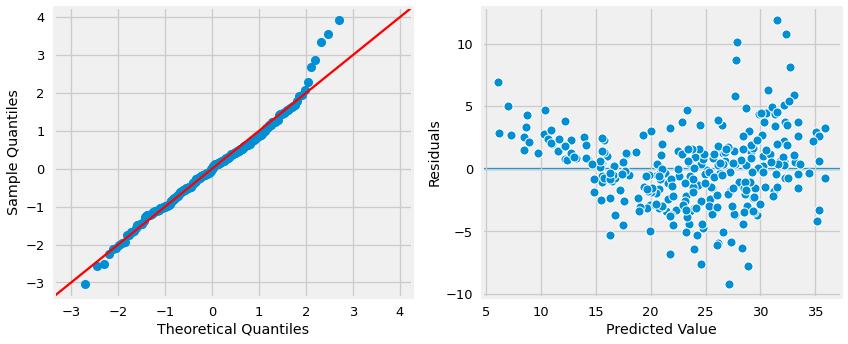

In [44]:
## instantiate an OLS model WITH the training data.
model_cln_cnst = sm.OLS(y_train_cln, X_train_df_cln_cnst)

## Fit the model and view the summary
result_cln_cnst = model_cln_cnst.fit()
sf.evaluate_ols(result_cln_cnst,X_train_df_cln_cnst, y_train_cln)

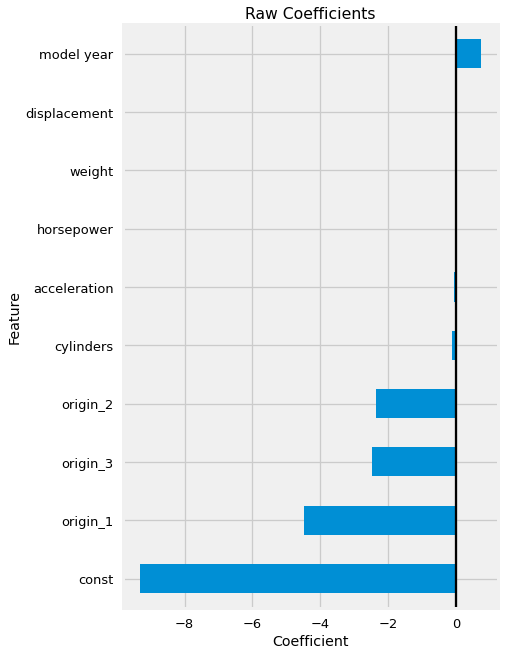

In [45]:
fig_raw =sf.plot_coeffs(result_cln_cnst, ohe_cols, include_const=True,title="Raw Coefficients")

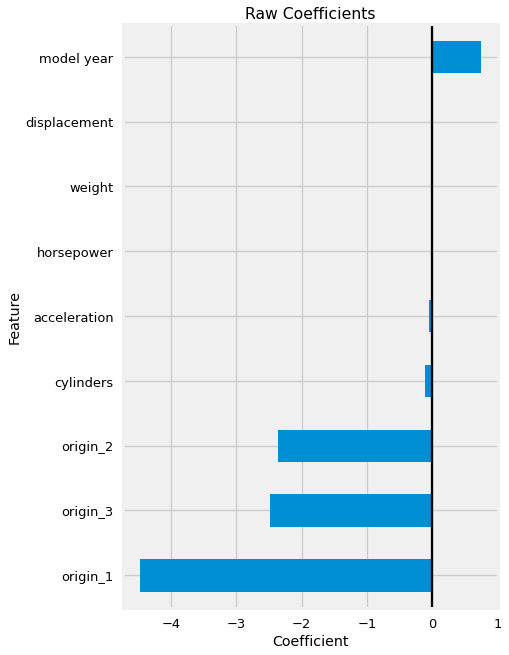

In [46]:
fig_raw =sf.plot_coeffs(result_cln_cnst, ohe_cols, include_const=False,title="Raw Coefficients")

In [47]:
fig_raw_zips =sf.plot_coeffs(result_cln_cnst, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - No Constant

In [48]:
X_train_scaled_df_cln.describe()

cylinders  displacement    horsepower        weight  acceleration  \
count  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02   
mean  -1.171902e-16 -3.392348e-17  1.449458e-16 -1.819532e-16 -4.934325e-16   
std    1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00   
min   -1.426822e+00 -1.219947e+00 -1.562182e+00 -1.555286e+00 -2.936077e+00   
25%   -8.355634e-01 -8.538746e-01 -7.525927e-01 -8.826038e-01 -6.442977e-01   
50%   -8.355634e-01 -4.977635e-01 -3.338394e-01 -2.468462e-01 -7.135286e-02   
75%    1.529471e+00  6.975745e-01  5.036672e-01  7.340370e-01  5.779847e-01   
max    1.529471e+00  2.376028e+00  3.155771e+00  2.602896e+00  3.060746e+00   

         model year    origin_1    origin_2    origin_3  
count  2.880000e+02  288.000000  288.000000  288.000000  
mean   1.739349e-15    0.652778    0.184028    0.163194  
std    1.001741e+00    0.476916    0.388181    0.370186  
min   -1.637654e+00    0.000000    0.000000    0.000000  
25%   -8.226005e-01    0.000000    0.000000    0.000000  
50%   -7.546794e-03    1.000000    0.000000    0.000000  
75%    8.075069e-01    1.000000    0.000000    0.000000  
max    1.622561e+00    1.000000    1.000000    1.000000

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     178.5
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          5.24e-105
Time:                        14:51:41   Log-Likelihood:                -727.36
No. Observations:                 288   AIC:                             1473.
Df Residuals:                     279   BIC:                             1506.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.2052      0.646     -0.318      0.751      -1.477       1.066
displacement     1.0811      0.962      1.124      0.262      -0.812       2.974
horsepower      -0.7218      0.567     -1.273      0.204      -1.838       0.395
weight          -5.2617      0.707     -7.445      0.000      -6.653      -3.871
acceleration    -0.1552      0.291     -0.533      0.595      -0.729       0.418
model year       2.7485      0.207     13.305      0.000       2.342       3.155
origin_1        22.8625      0.254     90.057      0.000      22.363      23.362
origin_2        24.9841      0.494     50.625      0.000      24.013      25.956
origin_3        24.8508      0.507     49.040      0.000      23.853      25.848
==============================================================================
Omnibus:                       16.085   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.422
Skew:                           0.350   Prob(JB):                     1.83e-06
Kurtosis:                       4.309   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

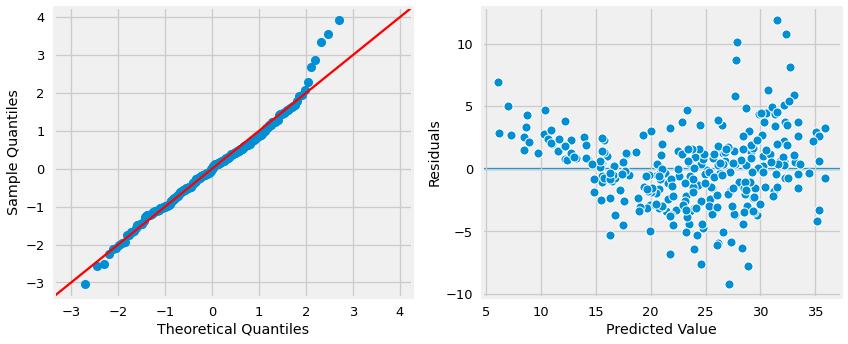

In [49]:
## instantiate an OLS model WITH the training data.
model_cln_scaled = sm.OLS(y_train_cln, X_train_scaled_df_cln)

## Fit the model and view the summary
result_cln_scaled = model_cln_scaled.fit()
sf.evaluate_ols(result_cln_scaled,X_train_scaled_df_cln, y_train_cln)

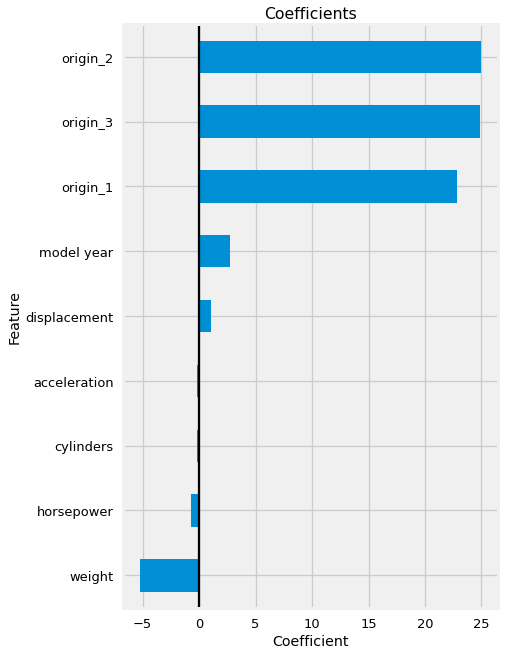

In [50]:
fig_scaled =sf.plot_coeffs(result_cln_scaled,ohe_cols,include_const=True)

In [51]:
fig_scaled_zips =sf.plot_coeffs(result_cln_scaled, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/CODE/stack_functions.py:159: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - with Constant

In [52]:
X_train_scaled_df_cln_cnst.describe()

cylinders  displacement    horsepower        weight  acceleration  \
count  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02   
mean  -1.171902e-16 -3.392348e-17  1.449458e-16 -1.819532e-16 -4.934325e-16   
std    1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00   
min   -1.426822e+00 -1.219947e+00 -1.562182e+00 -1.555286e+00 -2.936077e+00   
25%   -8.355634e-01 -8.538746e-01 -7.525927e-01 -8.826038e-01 -6.442977e-01   
50%   -8.355634e-01 -4.977635e-01 -3.338394e-01 -2.468462e-01 -7.135286e-02   
75%    1.529471e+00  6.975745e-01  5.036672e-01  7.340370e-01  5.779847e-01   
max    1.529471e+00  2.376028e+00  3.155771e+00  2.602896e+00  3.060746e+00   

         model year    origin_1    origin_2    origin_3  const  
count  2.880000e+02  288.000000  288.000000  288.000000  288.0  
mean   1.739349e-15    0.652778    0.184028    0.163194    1.0  
std    1.001741e+00    0.476916    0.388181    0.370186    0.0  
min   -1.637654e+00    0.000000    0.000000    0.000000    1.0  
25%   -8.226005e-01    0.000000    0.000000    0.000000    1.0  
50%   -7.546794e-03    1.000000    0.000000    0.000000    1.0  
75%    8.075069e-01    1.000000    0.000000    0.000000    1.0  
max    1.622561e+00    1.000000    1.000000    1.000000    1.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     178.5
Date:                Thu, 23 Jun 2022   Prob (F-statistic):          5.24e-105
Time:                        14:51:42   Log-Likelihood:                -727.36
No. Observations:                 288   AIC:                             1473.
Df Residuals:                     279   BIC:                             1506.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.2052      0.646     -0.318      0.751      -1.477       1.066
displacement     1.0811      0.962      1.124      0.262      -0.812       2.974
horsepower      -0.7218      0.567     -1.273      0.204      -1.838       0.395
weight          -5.2617      0.707     -7.445      0.000      -6.653      -3.871
acceleration    -0.1552      0.291     -0.533      0.595      -0.729       0.418
model year       2.7485      0.207     13.305      0.000       2.342       3.155
origin_1         4.6882      0.304     15.420      0.000       4.090       5.287
origin_2         6.8097      0.387     17.593      0.000       6.048       7.572
origin_3         6.6765      0.393     16.968      0.000       5.902       7.451
const           18.1743      0.183     99.231      0.000      17.814      18.535
==============================================================================
Omnibus:                       16.085   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.422
Skew:                           0.350   Prob(JB):                     1.83e-06
Kurtosis:                       4.309   Cond. No.                     1.87e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.56e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

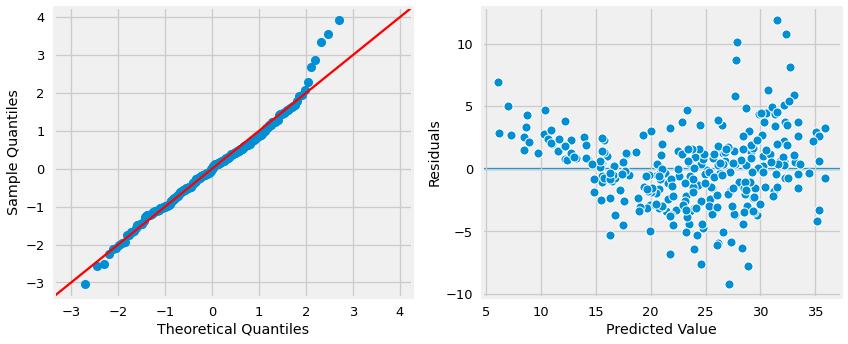

In [53]:
## instantiate an OLS model WITH the training data.
model_cln_scaled_cnst = sm.OLS(y_train_cln, X_train_scaled_df_cln_cnst)

## Fit the model and view the summary
result_cln_scaled_cnst = model_cln_scaled_cnst.fit()
sf.evaluate_ols(result_cln_scaled_cnst,X_train_scaled_df_cln_cnst, y_train_cln)

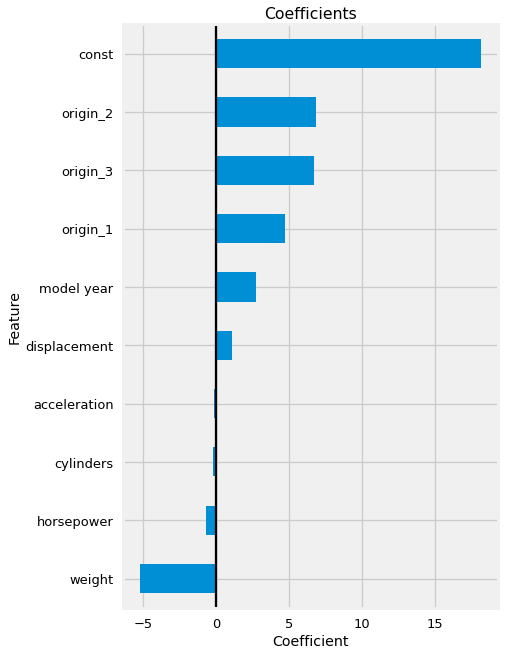

In [54]:
fig_scaled =sf.plot_coeffs(result_cln_scaled_cnst,ohe_cols,include_const=True)

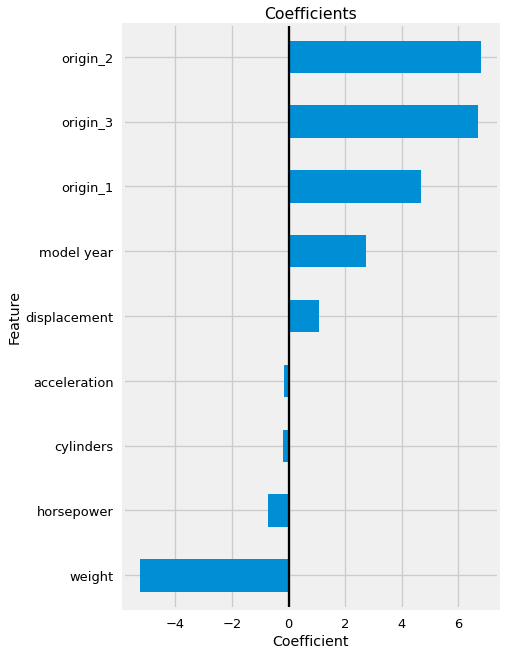

In [55]:
fig_scaled =sf.plot_coeffs(result_cln_scaled_cnst,ohe_cols,include_const=False)

# Adding Explanations

## Sklearn LinearRegression

> Pick 1 of the statsmodels models above to remake in sklearn for model explanations

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
## Making new var name sfor sklearn - update these to change model
ols_results = result_scaled_cnst
# sf.evaluate_ols(ols_results,X_tr,y_tr)
X_tr = X_train_scaled_df_cnst
X_te = X_test_scaled_df_cnst
y_tr = y_train
y_te = y_test

## If const in orig df, 
fit_intercept = 'const' in X_tr.columns

if fit_intercept==True:
    X_tr = X_tr.drop(columns='const')
    X_te = X_te.drop(columns='const')
fit_intercept

True

In [58]:
linreg = LinearRegression(fit_intercept=fit_intercept)
linreg.fit(X_tr, y_tr)
print(f"Train R^2: {format(linreg.score(X_tr,y_tr),'.2f')}")
print(f"Test R^2: {format(linreg.score(X_te,y_te),'.2f')}")
linreg.get_params()

Train R^2: 0.83
Test R^2: 0.80


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [59]:
coeffs = sf.get_coeffs(linreg,X_tr,name='LinReg Coeffs')
coeffs#.head(20)

cylinders       -0.822261
displacement     2.726648
horsepower      -1.107905
weight          -5.496578
acceleration     0.251363
model year       2.879470
origin_1        -2.255964
origin_2         1.216706
origin_3         1.039259
const           24.396217
Name: LinReg Coeffs, dtype: float64

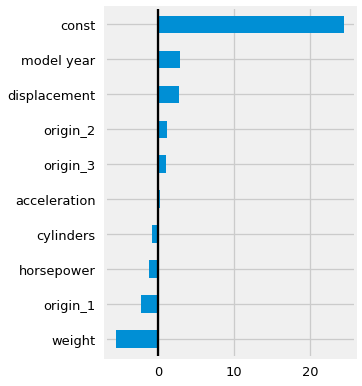

In [60]:
ax = coeffs.drop(ohe_cols).sort_values().plot(kind='barh',figsize=(4,6))
ax.axvline(0,color='black')

In [61]:
if len(ohe_cols)>1:

    ax = coeffs[ohe_cols].sort_values().plot(kind='barh',figsize=(4,6))
    ax.axvline(0,color='black')

In [62]:
## save 1 df of skelarn vs ols coeffs
compare_coeffs = pd.DataFrame({'OLS':ols_results.params,
                              'LinReg':coeffs}).round(2)
compare_coeffs['Agree?'] = compare_coeffs['OLS']==compare_coeffs['LinReg']

display(compare_coeffs.round(3))
compare_coeffs['Agree?'].value_counts(1)
#compare_coeffs.style.format({'OLS':"{:,.2f}","LinReg":"{:,.2f}"})

OLS  LinReg  Agree?
cylinders     -0.82   -0.82    True
displacement   2.73    2.73    True
horsepower    -1.11   -1.11    True
weight        -5.50   -5.50    True
acceleration   0.25    0.25    True
model year     2.88    2.88    True
origin_1       3.84   -2.26   False
origin_2       7.32    1.22   False
origin_3       7.14    1.04   False
const         18.30   24.40   False

True     0.6
False    0.4
Name: Agree?, dtype: float64

In [63]:
compare_coeffs[compare_coeffs['Agree?']==True]

OLS  LinReg  Agree?
cylinders    -0.82   -0.82    True
displacement  2.73    2.73    True
horsepower   -1.11   -1.11    True
weight       -5.50   -5.50    True
acceleration  0.25    0.25    True
model year    2.88    2.88    True

In [64]:
compare_coeffs[compare_coeffs['Agree?']==False]

OLS  LinReg  Agree?
origin_1   3.84   -2.26   False
origin_2   7.32    1.22   False
origin_3   7.14    1.04   False
const     18.30   24.40   False

In [65]:
compare_coeffs.style.bar()

> ISSUE WITH COEFFICIENTS NOT MATCHING - SEE IF TRUE FOR OTHER DATASETS. 

### Shap

In [66]:
import shap
shap.initjs()

shap.__version__

'0.41.0'

In [67]:
## sampling 200 rows from training data
X_shap = shap.sample(X_tr,nsamples=200,random_state=321)

In [68]:
## Creating explainer from model and getting shap values
explainer = shap.LinearExplainer(linreg,X_shap)
shap_values = explainer(X_shap)
shap_values.shape

(200, 9)

In [69]:
# [i for i in dir(shap_values) if not i.startswith("_")]

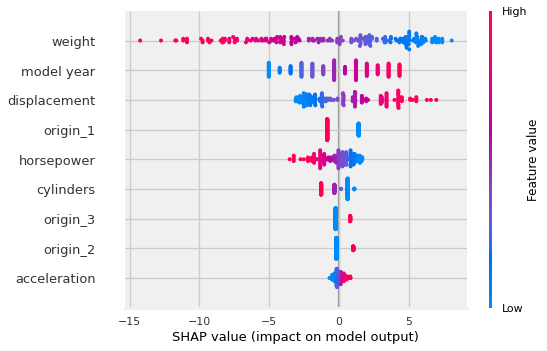

In [70]:
shap.summary_plot(shap_values)

In [71]:
explainer.expected_value

24.077736579440174

In [72]:
shap.force_plot(explainer.expected_value,shap_values= shap_values.values, features=X_shap)       

## RandomForest

In [73]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_tr,y_tr)

RandomForestRegressor()

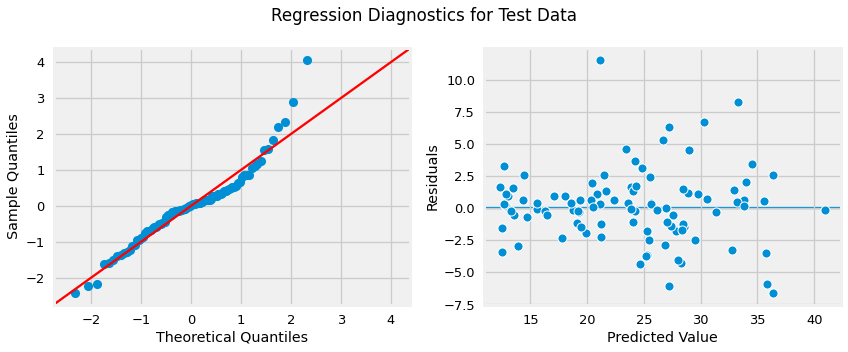

Score
Metric Split       
R^2    Train   0.98
       Test    0.86
RMSE   Train   1.04
       Test    2.81

In [74]:
scores = sf.evaluate_regression(rf_reg,X_te, y_te, X_train_df=X_tr, y_train=y_tr,
                            return_scores=True)

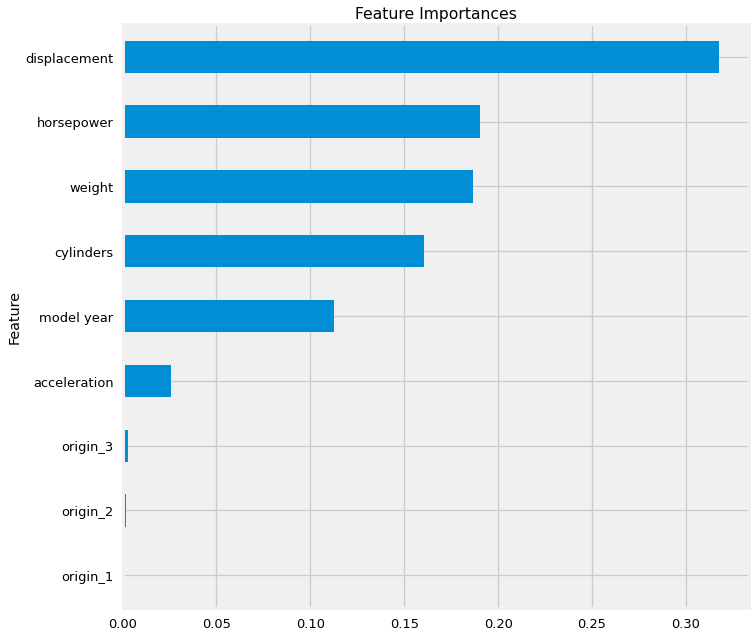

In [75]:
importances = sf.get_importance(rf_reg,X_test_df,top_n=50)

### Permutation Importance

In [76]:
from sklearn.inspection import permutation_importance
## Permutation importance takes a fit mode and test data. 
r = permutation_importance(linreg, X_tr, y_tr,
#                            n_repeats=30
                          )
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [77]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_tr.columns,
                           name = 'permutation importance')
permutation_importances

cylinders       0.026240
displacement    0.237412
horsepower      0.042097
weight          1.026737
acceleration    0.001975
model year      0.281786
origin_1        0.041336
origin_2        0.007194
origin_3        0.006239
Name: permutation importance, dtype: float64

<AxesSubplot:>

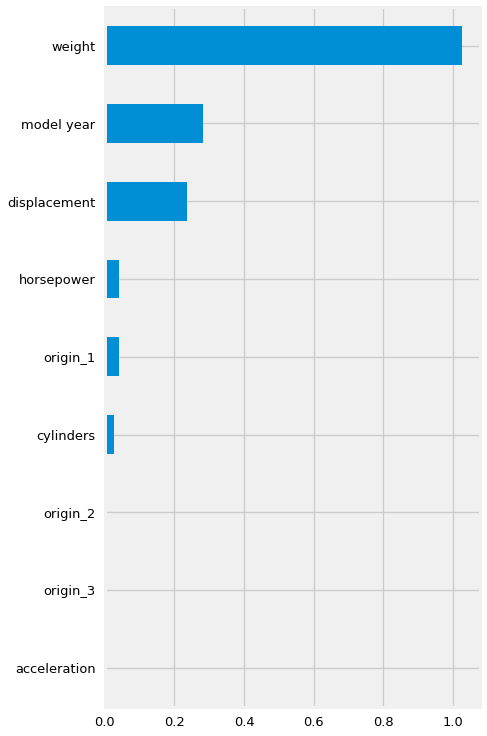

In [78]:
permutation_importances.sort_values().tail(20).plot(kind='barh',figsize=(6,12))

In [79]:
X_shap = shap.sample(X_tr,nsamples=200,random_state=321)

In [80]:
explainer = shap.TreeExplainer(rf_reg,X_shap)
shap_values = explainer(X_shap)

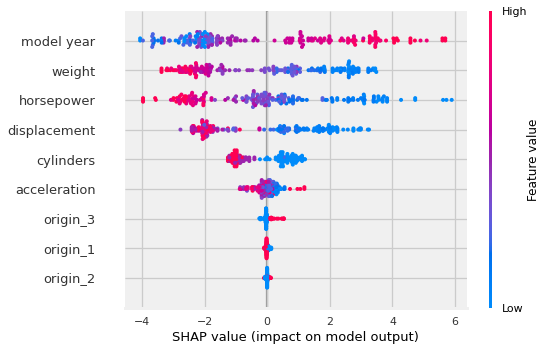

In [81]:
shap.summary_plot(shap_values)

In [82]:
shap.force_plot(explainer.expected_value,shap_values= shap_values.values, features=X_shap)       